In [35]:
!pip install gymnasium

In [36]:
from typing import Dict, List, Optional, Tuple
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

## TSP Environment

In [37]:
class TSP(gym.Env):
    """Traveling Salesman Problem (TSP) RL environment for persistent monitoring.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets in the least number of steps, with rewards determined by the distance traveled.
    """

    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): Number of targets the agent needs to visit.
            max_area (int): Max Square area where the targets are defined. Defaults to 30
            seed (int, optional): Random seed for reproducibility. Defaults to None.
        """
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        # Observation Space
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        # Action Space
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0

        self.loc: int = 0
        self.visited_targets: List = []
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(
        self, action: int
    ) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        reward = self._get_rewards(past_loc, next_loc)
        self.visited_targets.append(next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        points = []

        # Generate 2D points 10x10 grid
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        """Calculate the distance matrix between all target locations.

        Args:
            locations (List): List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            past_loc (int): Previous location of the agent.
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -10000
        return reward


# Monte Carlo - First Visit

[First Visit] Episode 0, Epsilon: 0.0995
[First Visit] Episode 100, Epsilon: 0.0603
[First Visit] Episode 200, Epsilon: 0.0365
[First Visit] Episode 300, Epsilon: 0.0221
[First Visit] Episode 400, Epsilon: 0.0134
[First Visit] Episode 500, Epsilon: 0.0100
[First Visit] Episode 600, Epsilon: 0.0100
[First Visit] Episode 700, Epsilon: 0.0100
[First Visit] Episode 800, Epsilon: 0.0100
[First Visit] Episode 900, Epsilon: 0.0100
Optimal Policy (First Visit): [ 0 45 34 16 47 10 20 19 18 13 36 43 48  8 35 41 22 35 31 44 43 47 43  3
 48 48 41 16 29 39 23  6 21 45 45 22 13 40 32 13 44 19 32 34 23 21 22 22
 13 27]


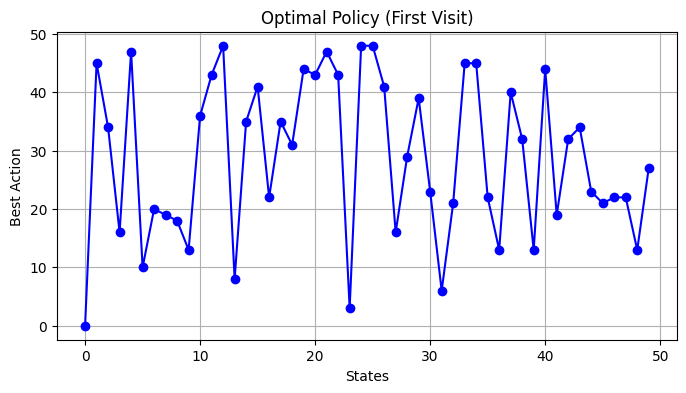

In [38]:
def first_visit_mc(env, num_episodes=1000, discount_factor=0.9, epsilon=0.1, epsilon_decay=0.995, seed=42):
    np.random.seed(seed)  # Set the seed for reproducibility and for less repeatability
    Q = np.zeros((env.num_targets, env.num_targets))
    returns = defaultdict(list)

    for episode in range(num_episodes):
        episode_history, G = [], 0
        state, _ = env.reset()
        state = int(state[0])
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[state])  # Exploit

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = int(next_state[0])
            episode_history.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        # Monte Carlo update
        for state, action, reward in reversed(episode_history):
            G = reward + discount_factor * G
            if (state, action) not in returns:
                returns[(state, action)].append(G)
                Q[state, action] = np.mean(returns[(state, action)])

        epsilon = max(0.01, epsilon * epsilon_decay)  # Decay epsilon

        if episode % 100 == 0:
            print(f"[First Visit] Episode {episode}, Epsilon: {epsilon:.4f}")

    return np.argmax(Q, axis=1)

def visualize_policy(policy, title="Optimal Policy (First Visit)"):
    plt.figure(figsize=(8, 4))
    plt.plot(policy, marker='o', linestyle='-', color='b')
    plt.title(title)
    plt.xlabel('States')
    plt.ylabel('Best Action')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    env = TSP(50)
    policy_first_visit = first_visit_mc(env)
    print("Optimal Policy (First Visit):", policy_first_visit)
    visualize_policy(policy_first_visit)


# Monte Carlo - Every Visit

[Every Visit] Episode 0, Epsilon: 0.0995
[Every Visit] Episode 100, Epsilon: 0.0603
[Every Visit] Episode 200, Epsilon: 0.0365
[Every Visit] Episode 300, Epsilon: 0.0221
[Every Visit] Episode 400, Epsilon: 0.0134
[Every Visit] Episode 500, Epsilon: 0.0100
[Every Visit] Episode 600, Epsilon: 0.0100
[Every Visit] Episode 700, Epsilon: 0.0100
[Every Visit] Episode 800, Epsilon: 0.0100
[Every Visit] Episode 900, Epsilon: 0.0100
Optimal Policy (Every Visit): [46 47 36 20 49 23 48 28 10  8  7 25 31 43 41 33 19 41  4 34 15 12  9 17
 39 22  9 18 36 15 32 13 31 16 44  5 30 38 32  6  4 15 27 23  1 12 42 13
 11 24]


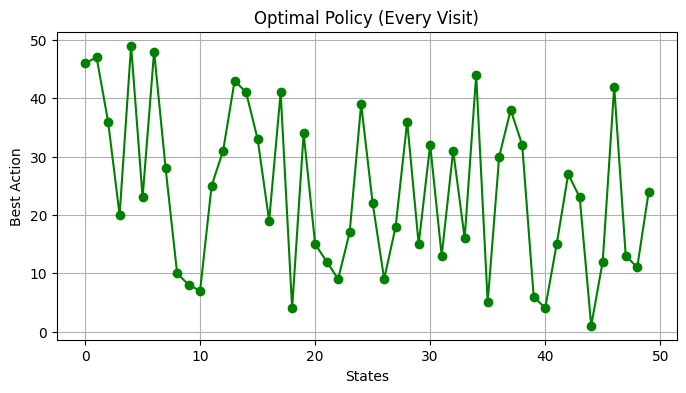

In [39]:
def every_visit_mc(env, num_episodes=1000, discount_factor=0.9, epsilon=0.1, epsilon_decay=0.995, seed=42):
    np.random.seed(seed)  # Set the seed for reproducibility and less repeatability
    Q = np.zeros((env.num_targets, env.num_targets))
    returns = defaultdict(list)

    for episode in range(num_episodes):
        episode_history, G = [], 0
        state, _ = env.reset()
        state = int(state[0])
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[state])  # Exploit

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = int(next_state[0])
            episode_history.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        # Monte Carlo update (Every-visit)
        for state, action, reward in reversed(episode_history):
            G = reward + discount_factor * G
            returns[(state, action)].append(G)
            Q[state, action] = np.mean(returns[(state, action)])

        epsilon = max(0.01, epsilon * epsilon_decay)  # Decay epsilon

        if episode % 100 == 0:
            print(f"[Every Visit] Episode {episode}, Epsilon: {epsilon:.4f}")

    return np.argmax(Q, axis=1)

def visualize_policy(policy, title="Optimal Policy (Every Visit)"):
    plt.figure(figsize=(8, 4))
    plt.plot(policy, marker='o', linestyle='-', color='g')
    plt.title(title)
    plt.xlabel('States')
    plt.ylabel('Best Action')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    env = TSP(50)
    policy_every_visit = every_visit_mc(env)
    print("Optimal Policy (Every Visit):", policy_every_visit)
    visualize_policy(policy_every_visit, title="Optimal Policy (Every Visit)")
